In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(0, "../../../pymc/")

import pymc as pm

In [2]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 8998
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")

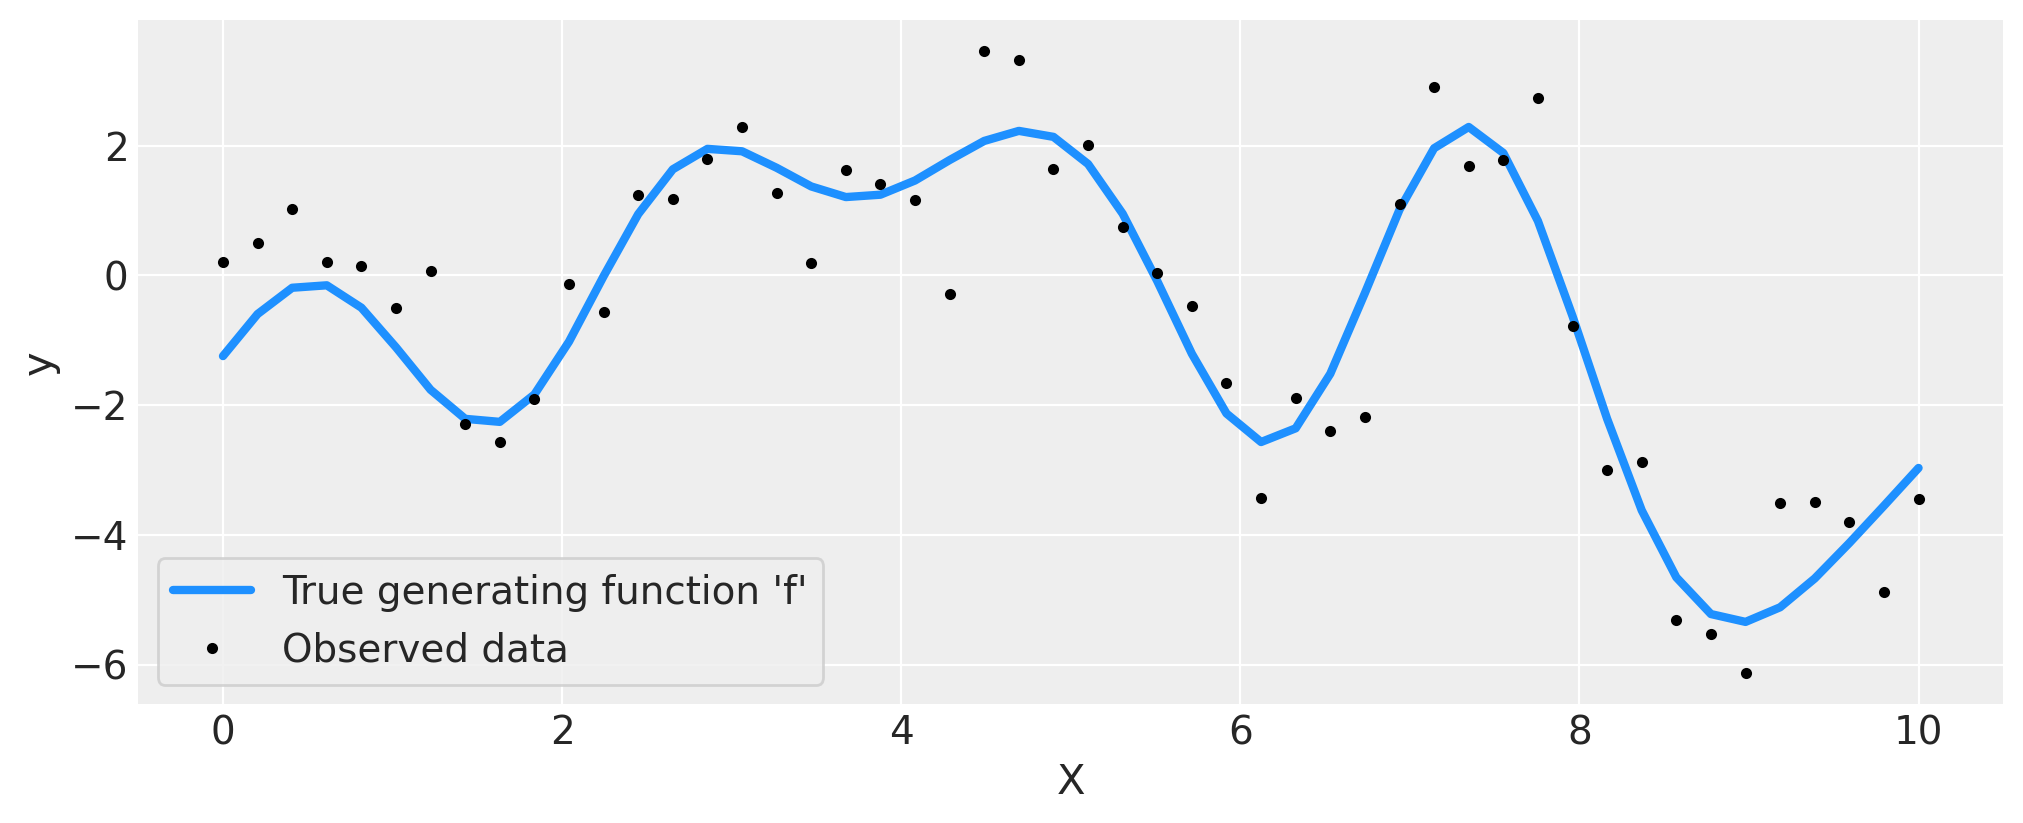

In [3]:
n = 50  # The number of data points
X = np.linspace(0, 10, n)[:, None]  # The inputs to the GP must be arranged as a column vector

# Define the true covariance function and its parameters
ell_true = 1.0
eta_true = 4.0
cov_func = eta_true**2 * pm.gp.cov.ExpQuad(1, ell_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC built on top of Theano
f_true = pm.draw(pm.MvNormal.dist(mu=mean_func(X), cov=cov_func(X)), 1, random_seed=rng)

# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
sigma_true = 1.0
nu_true = 5.0
y = f_true + sigma_true * rng.normal(size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")
ax.set_xlabel("X")
ax.set_ylabel("y")
plt.legend(frameon=True);

The data above shows the observations, marked with black dots, of the unknown function $f(x)$ that has been corrupted by noise.  The true function is in blue.  

### Coding the model in PyMC

Here's the model in PyMC.  We use an informative {class}`pm.Gamma(alpha=2, beta=1)` prior over the lengthscale parameter, and weakly informative {class}`pm.HalfNormal(sigma=5)` priors over the covariance function scale, and noise scale.  A `pm.Gamma(2, 0.5)` prior is assigned to the degrees of freedom parameter of the noise.  Finally, a GP prior is placed on the unknown function.  For more information on choosing priors in Gaussian process models, check out some of [recommendations by the Stan folks](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations#priors-for-gaussian-processes).

In [4]:
import pymc.sampling_jax

/Users/andre/development/pymc-examples/examples/gaussian_processes/../../../pymc/pymc/sampling_jax.py:37: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [5]:
coords = {"X": np.arange(len(y))}
with pm.Model(coords=coords) as model:
    ell = pm.Gamma("ell", alpha=2, beta=1)
    eta = pm.HalfNormal("eta", sigma=5)

    cov = eta**2 * pm.gp.cov.ExpQuad(1, ell)
    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=X, dims="X")

    sigma = pm.HalfNormal("sigma", sigma=2.0)
    y_ = pm.Normal("y", mu=f, sigma=sigma, observed=y, dims="X")

    idata_latent = pm.sampling_jax.sample_numpyro_nuts(1000, tune=1000, chains=2)

Compiling...
Compilation time =  0:00:10.349087
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:27.648578
Transforming variables...
Transformation time =  0:00:01.306511
Computing Log Likelihood...
Log Likelihood time =  0:00:00.857834


In [ ]:
# check Rhat, values above 1 may indicate convergence issues
n_nonconverged = int(
    np.sum(az.rhat(idata)[["eta", "ell", "sigma", "f_rotated_"]].to_array() > 1.03).values
)
if n_nonconverged == 0:
    print("No Rhat values above 1.03, \N{check mark}")
else:
    print(f"The MCMC chains for {n_nonconverged} RVs appear not to have converged.")

In [7]:
coords = {"X": np.arange(len(y))}
with pm.Model(coords=coords) as model:
    ell = pm.Gamma("ell", alpha=2, beta=1)
    eta = pm.HalfNormal("eta", sigma=5)

    cov = eta**2 * pm.gp.cov.ExpQuad(1, ell)
    gp = pm.gp.Marginal(cov_func=cov)

    sigma = pm.HalfNormal("sigma", sigma=2.0)
    y_ = gp.marginal_likelihood("y", X=X, y=y, noise=sigma)

    idata_marginal = pm.sampling_jax.sample_numpyro_nuts(1000, tune=1000, chains=2)

Compiling...
Compilation time =  0:00:11.426210
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:06.819815
Transforming variables...
Transformation time =  0:00:00.012108
Computing Log Likelihood...
Log Likelihood time =  0:00:01.662823


In [10]:
idata_latent.posterior

<xarray.Dataset>
Dimensions:     (chain: 2, draw: 1000, X: 50)
Coordinates:
  * chain       (chain) int64 0 1
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * X           (X) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Data variables:
    f_rotated_  (chain, draw, X) float64 0.01642 -0.2424 ... 0.4469 -0.5098
    ell         (chain, draw) float64 0.8065 0.8167 0.6386 ... 0.6747 0.4975
    eta         (chain, draw) float64 2.356 2.847 3.966 ... 3.869 2.445 2.252
    sigma       (chain, draw) float64 0.996 0.7481 0.7954 ... 0.7809 0.9903
    f           (chain, draw, X) float64 0.03869 -0.1048 ... -3.659 -2.783
Attributes:
    created_at:     2022-09-20T23:56:43.149365
    arviz_version:  0.12.1

In [11]:
idata_marginal.posterior

<xarray.Dataset>
Dimensions:  (chain: 2, draw: 1000)
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    ell      (chain, draw) float64 0.8299 0.6123 0.895 ... 0.7949 0.7512 0.6605
    eta      (chain, draw) float64 5.149 2.318 3.273 3.411 ... 2.629 2.207 2.384
    sigma    (chain, draw) float64 0.7567 1.103 0.8167 ... 0.9528 1.127 0.858
Attributes:
    created_at:     2022-09-20T23:57:18.762433
    arviz_version:  0.12.1

Marginal, likelihood gaussian, prior gaussian.  Marginal = marginalize out f

$$ \int L(y | f, \ell, \sigma) P(f, \ell, \sigma) df = L(y | \ell, \sigma) $$